In [40]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeRegressor
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV

# Scikitlearn
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error


# DATA
from ucimlrepo import fetch_ucirepo

In [2]:
pip install catboost

  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/101.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/101.1 MB 656.4 kB/s eta 0:02:34
   ---------------------------------------- 0.1/101.1 MB 901.1 kB/s eta 0:01:53
   ---------------------------------------- 0.2/101.1 MB 1.3 MB/s eta 0:01:18
   ---------------------------------------- 0.3/101.1 MB 1.5 MB/s eta 0:01:08
   ---------------------------------------- 0.4/101.1 MB 1.5 MB/s eta 0:01:06
   ---------------------------------------- 0.5/101.1 MB 1.6 MB/s eta 0:01:05
   ---------------------------------------- 0.6/101.1 MB 1.5 MB/s eta 0:01:06
   ---------------------------------------- 0.6/101.1 MB 1.6 MB/s eta 0:01:05
   ---------------------------------------- 0.7/101.1 MB 1.6 MB/s eta 0:01:05
   ---------------------------------------- 0.7/101.1 MB 1.5 MB/s eta 0:01:06
   ------

In [43]:
def load_data_from_uci(id_code):

  # fetch dataset
  uci_data = fetch_ucirepo(id=id_code)

  # data (as pandas dataframes)
  input_features = uci_data.data.features
  target_feature = uci_data.data.targets
  metadata = uci_data.data.metadata
  variables_info = uci_data.data.variables

  return input_features, target_feature, metadata, variables_info

In [44]:
X, y, metadata, variables_info= load_data_from_uci(id_code=242)

In [45]:
X_mapping = {
    'X1': 'Relative Compactness',
    'X2': 'Surface Area',
    'X3': 'Wall Area',
    'X4': 'Roof Area',
    'X5': 'Overall Height',
    'X6': 'Orientation',
    'X7': 'Glazing Area',
    'X8': 'Glazing Area Distribution'
}

y_mapping = {
    'Y1': "Heating Load (HL)",
    'Y2': "Cooling Load (CL)"
}

X.rename(columns=X_mapping, inplace=True)
y.rename(columns=y_mapping, inplace=True)
y

,Heating Load (HL),Cooling Load (CL)
0,15.55,21.33
1,15.55,21.33
2,15.55,21.33
3,15.55,21.33
4,20.84,28.28
...,...,...
763,17.88,21.40
764,16.54,16.88
765,16.44,17.11
766,16.48,16.61


## Scale and OHE

In [46]:
num_features = ['Relative Compactness', 'Surface Area','Wall Area','Roof Area', 'Overall Height', 
                       'Orientation','Glazing Area','Glazing Area Distribution']
cat_features = ['Orientation','Glazing Area Distribution']

preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder', OneHotEncoder(), cat_features),
        ('StandardScaler', StandardScaler(), num_features)
    ]
)

X_scaled = preprocessor.fit_transform(X)


In [28]:
y_cooling=y['Heating Load (HL)']
y_heating=y['Cooling Load (CL)']

## Split the dataset

In [92]:
# Split the data into training and testing sets
X_train, X_test, y_train,y_test = train_test_split(
    X,y,test_size=0.2, random_state=42
)

In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train_heating, y_test_heating, y_train_cooling, y_test_cooling = train_test_split(
    X,
    y_heating, y_cooling,
    test_size=0.2, random_state=42
)

### Evaluate the model

In [91]:
def evaluate_techniques(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [139]:
models = {
    "Random Forest": RandomForestRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(verbose=0),
    "Linear Regression": LinearRegression(),
    "XGBRegressor": XGBRegressor(),
    "CatBoosting Regressor": CatBoostRegressor(),
    "AdaBoost Regressor": AdaBoostRegressor(),
        }


# Hyperparameter            
params={
    "Decision Tree": {
        'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                    # 'splitter':['best','random'],
                    # 'max_features':['sqrt','log2'],
            },
    "Random Forest":{
                    # 'criterion':['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
                 
                    # 'max_features':['sqrt','log2',None],
        'n_estimators': [8,16,32,64,128,256]
            },
    "Gradient Boosting":{
                    # 'loss':['squared_error', 'huber', 'absolute_error', 'quantile'],
        'learning_rate':[.1,.01,.05,.001],
        'subsample':[0.6,0.7,0.75,0.8,0.85,0.9],
                    # 'criterion':['squared_error', 'friedman_mse'],
                    # 'max_features':['auto','sqrt','log2'],
        'n_estimators': [8,16,32,64,128,256]
            },
    "Linear Regression":{},
    "XGBRegressor":{
        'learning_rate':[.1,.01,.05,.001],
        'n_estimators': [8,16,32,64,128,256]
                },
    "CatBoosting Regressor":{
        'depth': [6,8,10],
        'learning_rate': [0.01, 0.05, 0.1],
        'iterations': [30, 50, 100]
                },
    "AdaBoost Regressor":{
        'learning_rate':[.1,.01,0.5,.001],
                    # 'loss':['linear','square','exponential'],
        'n_estimators': [8,16,32,64,128,256]
                }
                
            }

### Run all models and evaluate 

In [179]:
def evaluate_models(X_train, y_train, X_test, y_test, models, param):
    try:
        report = {}
        
        # Separate target variables
        y_train_h = y_train['Heating Load (HL)']  # Heating load
        y_train_c = y_train['Cooling Load (CL)']  # Cooling load
        y_test_h = y_test['Heating Load (HL)']
        y_test_c = y_test['Cooling Load (CL)']

        for model_name, model in models.items():
            para = param.get(model_name, {})  # Get parameters for the current model
            
            if model_name == "CatBoosting Regressor":
                model.set_params(logging_level='Silent')
            elif model_name == "XGBRegressor":
                model.set_params(verbosity=0, silent=True)
            
            # GridSearch for Heating load
            gs_h = GridSearchCV(model, para, cv=3)
            gs_h.fit(X_train, y_train_h)

            if gs_h.best_params_:
                best_params_h = gs_h.best_params_
                model_h = model.__class__(**best_params_h)  # Create a new instance with best params
                model_h.fit(X_train, y_train_h)
            else:
                print(f"No best parameters found for {model_name} (Heating load), using default parameters.")
                model_h = model.fit(X_train, y_train_h)  # Use default parameters

            # GridSearch for Cooling load
            gs_c = GridSearchCV(model, para, cv=3)
            gs_c.fit(X_train, y_train_c)

            if gs_c.best_params_:
                best_params_c = gs_c.best_params_
                model_c = model.__class__(**best_params_c)  # Create a new instance with best params
                model_c.fit(X_train, y_train_c)
            else:
                print(f"No best parameters found for {model_name} (Cooling load), using default parameters.")
                model_c = model.fit(X_train, y_train_c)  # Use default parameters

            
            # Predictions
            y_test_pred_h = model_h.predict(X_test)
            y_test_pred_c = model_c.predict(X_test)

            # Evaluate
            model_test_mae_h, model_test_rmse_h, model_test_r2_h = evaluate_techniques(y_test_h, y_test_pred_h)
            model_test_mae_c, model_test_rmse_c, model_test_r2_c = evaluate_techniques(y_test_c, y_test_pred_c)

            # Store results in report dictionary
            report[model_name] = {
                "Heating_load": {
                    "MAE": model_test_mae_h,
                    "RMSE": model_test_rmse_h,
                    "R2_score": model_test_r2_h,
                    "Best_params": best_params_h
                },
                "Cooling_load": {
                    "MAE": model_test_mae_c,
                    "RMSE": model_test_rmse_c,
                    "R2_score": model_test_r2_c,
                    "Best_params": best_params_c
                }
            }

#         print(report)
        return report

    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage (assuming evaluate_techniques is defined and models/params are provided)


report = evaluate_models(X_train, y_train, X_test, y_test, models, params)


In [181]:
# Create a DataFrame from the report

df_result_h = pd.DataFrame([(model_name,
                             report[model_name]['Heating_load']['R2_score'],
                             report[model_name]['Heating_load']['Best_params'])
                            for model_name in report],
                           columns=['Model_h', 'R2_score_h', "Best_params"])

df_result_c = pd.DataFrame([(model_name, 
                             report[model_name]['Cooling_load']['R2_score'],
                             report[model_name]['Cooling_load']['Best_params']) 
                            for model_name in report],
                           columns=['Model_c', 'R2_score_c', "Best_params"])

df_both = pd.concat([df_result_h, df_result_c], axis=1)


# Sort DataFrame by R2_score in descending order
df_sorted = df_both.sort_values(by=['R2_score_h','R2_score_c'], ascending=False)

df_sorted



,Model_h,R2_score_h,Best_params,Model_c,R2_score_c,Best_params
4,XGBRegressor,0.998489,"{'learning_rate': 0.1, 'n_estimators': 256}",XGBRegressor,0.992246,"{'learning_rate': 0.1, 'n_estimators': 256}"
5,CatBoosting Regressor,0.998230,"{'depth': 6, 'iterations': 100, 'learning_rate...",CatBoosting Regressor,0.991133,"{'depth': 8, 'iterations': 100, 'learning_rate..."
2,Gradient Boosting,0.998154,"{'learning_rate': 0.1, 'n_estimators': 256, 's...",Gradient Boosting,0.982182,"{'learning_rate': 0.1, 'n_estimators': 256, 's..."
0,Random Forest,0.997747,{'n_estimators': 64},Random Forest,0.966464,{'n_estimators': 128}
1,Decision Tree,0.996750,{'criterion': 'absolute_error'},Decision Tree,0.956093,{'criterion': 'squared_error'}
6,AdaBoost Regressor,0.962449,"{'learning_rate': 0.5, 'n_estimators': 64}",AdaBoost Regressor,0.937869,"{'learning_rate': 0.5, 'n_estimators': 256}"
3,Linear Regression,0.865101,"{'learning_rate': 0.1, 'n_estimators': 256, 's...",Linear Regression,0.893244,"{'learning_rate': 0.1, 'n_estimators': 256, 's..."


From the df above, the best model for both targets is XGBRegressor

### XGBRegressor 

In [182]:
xgb = XGBRegressor(learning_rate=0.1,n_estimators=256)
xgb_model = xgb.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print("Accuracy of the model is %.2f" %score)

Accuracy of the model is 99.51


### Plot y_pred and y_true

Text(0, 0.5, 'Prediction')

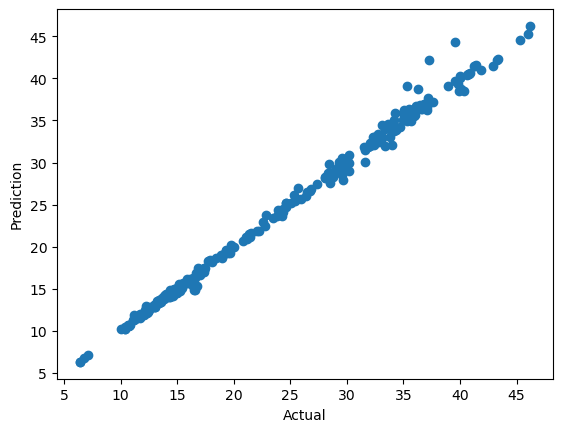

In [183]:
plt.scatter(y_test, y_pred);
plt.xlabel('Actual')
plt.ylabel('Prediction')

In [195]:
y_train_h = y_train['Heating Load (HL)']  # Heating load
y_train_c = y_train['Cooling Load (CL)']  # Cooling load
y_test_h = y_test['Heating Load (HL)']
y_test_c = y_test['Cooling Load (CL)']
y_pred_h = y_pred[:, 0]
y_pred_c = y_pred[:, 1]

<Axes: xlabel='Heating Load (HL)'>

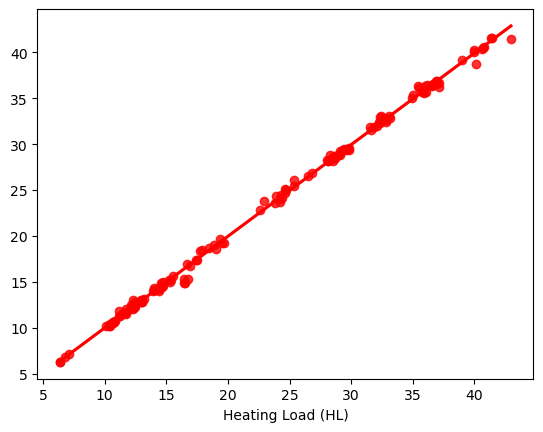

In [196]:
sns.regplot(x=y_test_h, y=y_pred_h,ci=None,color='r')

<Axes: xlabel='Cooling Load (CL)'>

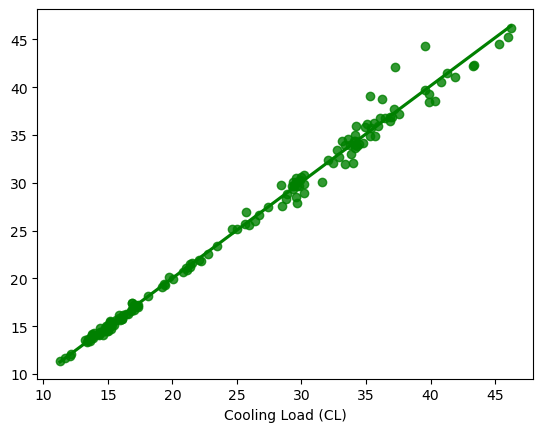

In [197]:
sns.regplot(x=y_test_c, y=y_pred_c,ci=None,color='g')

### Difference between Actual and Predicted Values

In [198]:
pred_vs_actual_h=pd.DataFrame({'Actual_Value':y_test_h, "Predicted_Value":y_pred_h, "Difference":y_test_h-y_pred_h})
pred_vs_actual_h

,Actual_Value,Predicted_Value,Difference
668,16.47,14.879861,1.590139
324,13.17,13.214611,-0.044611
624,32.82,32.419510,0.400490
690,41.32,41.486485,-0.166485
473,16.69,16.935875,-0.245875
...,...,...,...
355,38.98,39.100346,-0.120346
534,36.66,36.401398,0.258602
344,29.34,29.363621,-0.023621
296,29.54,29.381998,0.158002


In [199]:
pred_vs_actual_c=pd.DataFrame({'Actual_Value':y_test_c, "Predicted_Value":y_pred_c, "Difference":y_test_c-y_pred_c})
pred_vs_actual_c

,Actual_Value,Predicted_Value,Difference
668,16.90,16.852160,0.047840
324,16.39,16.254534,0.135466
624,32.78,33.396751,-0.616751
690,46.23,46.219059,0.010941
473,19.76,20.156479,-0.396479
...,...,...,...
355,45.97,45.217869,0.752131
534,35.92,35.933865,-0.013865
344,33.37,32.018909,1.351091
296,33.98,32.121185,1.858815


### Try to predict with a random row

In [202]:
random_row=X_test.iloc[[59]]
random_row

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution
404,0.76,661.5,416.5,122.5,7.0,2,0.25,3


In [234]:
random_row_pred = xgb_model.predict(random_row)
random_row_pred = random_row_pred.flatten() # transform into 1d array
random_row_pred

array([36.30746, 36.76344], dtype=float32)

In [240]:
random_row_true = y_test.iloc[[59]]
random_row_true = random_row_true.values # transform into np array
random_row_true = random_row_true.flatten() # transform into 1d array
random_row_true

array([35.99, 36.07])

In [242]:
pred_vs_actual_random=pd.DataFrame({'Actual_Value':random_row_true, "Predicted_Value":random_row_pred, 
                                    "Difference":random_row_true-random_row_pred},
                                  index=["Heating Load (HL)", "Cooling Load (CL)"])
pred_vs_actual_random

,Actual_Value,Predicted_Value,Difference
Heating Load (HL),35.99,36.307461,-0.317461
Cooling Load (CL),36.07,36.763439,-0.693439
